# **Workshop Demo**: Natural Language Processing (NLP) in Financial Text Analysis with Python

A beginner-friendly to intermediate introduction to NLP techniques for sentiment analysis and named entityt recognition (NER) using **[Python](https://www.python.org)**
- **Objectives**
  - Apply text preprocessing on sample dataset using `NLTK` library
  - Create a `TF-IDF` feature extraction and correct training/testing sets
  - Use [logistic regression](https://www.geeksforgeeks.org/understanding-logistic-regression/) for sentiment analysis, and evaluate using appropriate benchmarking metrics
  - Use a deep learning pre-trained [transformer](https://www.ibm.com/topics/transformer-model) for sentiment analysis
  - Introduction to basic named entity recognition (NER) using `spaCy`

- **Supplementary**
  - Additional implementation of popular industry models
  - Best practices used in approaching NLP models

# 1. Importing Libraries and Loading the Dataset

- We will be using `Natural Language Toolkit` ([NLTK](https://www.nltk.org)), a very popular Python library used for NLP. It is highly versatile and gives us lots of processing tools, as well as tokenizers, tree parsers visualizations, etc
- For our basic machine learning logistic regression and benchmarking, we will use a powerful predictive data analysis library called `scikit-learn` (or [sklearn](https://scikit-learn.org/stable/))
- We will be using a Kaggle dataset on financial news classification, labeled by Percy Zheng and updated by Nick Muchi through Hugging Face. Here is the dataset: [[link](https://huggingface.co/datasets/nickmuchi/financial-classification)]
  - This includes news titles and sentences from financial websites like CNBC, FT, etc
- Finally, we will use [Hugging Face](https://huggingface.co) and their `transformer` open-source [framework](https://huggingface.co/docs/transformers/en/index) for our pre-trained deep learning neural network ([FinBERT](https://medium.com/prosus-ai-tech-blog/finbert-financial-sentiment-analysis-with-bert-b277a3607101) model)



In [ ]:
"""
1. Importing Libraries and Loading the Dataset
"""

# import necessary libraries/dependencies for basic data handling
import pandas as pd
import torch # deep learning
import nltk
from nltk.tokenize import word_tokenize  # tokenization
from nltk.corpus import stopwords        # stopword definition
from nltk.stem import PorterStemmer      # stemming
from nltk.stem import WordNetLemmatizer  # lemmatization

# libraries for feature extraction and train/test split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# import dependencies for ML/DL and benchmarking
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# import dependencies for named entity recognition
import spacy
from collections import Counter

# download NLTK data if not already downloaded
nltk.download('punkt')      #
nltk.download('stopwords')  # English stop words to be filtered out
nltk.download('wordnet')    #

# loading Hugging Face dataset
!pip install datasets
from datasets import load_dataset


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 749.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.0 MB/s eta 0:00:00


In [ ]:
"""
1. Importing Libraries and Loading the Dataset (cont.)
"""

# load dataset from Hugging Face (originally Kaggle)
ds = load_dataset("nickmuchi/financial-classification")

# convert the default DatasetDict format to pandas DataFrame
train_df = ds['train'].to_pandas()
test_df = ds['test'].to_pandas()

# NOTE: we will merge the train/test to have our own split after text preprocessing
# you can use the Hugging Face DatasetDict format as well
df = pd.concat([train_df, test_df], ignore_index=True)

# assuming the columns are 'text' and 'labels'
X = df['text']
y = df['labels']

# display first few rows of the resulting DataFrame
print(df.head())

# size of dataset (using df.shape)
print(f"\nNumber of rows: {df.shape[0]}\nNumber of columns: {df.shape[1]}")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/935 [00:00<?, ?B/s]

dataset_infos.json:   0%|          | 0.00/768 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/378k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/44.1k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4551 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/506 [00:00<?, ? examples/s]

                                                text  labels
0  Finnish airline Finnair is starting the tempor...       0
1  The corresponding increase in the share capita...       1
2  In the third quarter of fiscal 2008 Efore swun...       0
3  ALEXANDRIA , Va. , Oct. 15 -- Aaron Moss of Ha...       1
4  Vaisala Oyj Stock exchange release 26.03.2010 ...       1

Number of rows: 5057
Number of columns: 2


# 2. Data Preprocessing

- Some basic data preprocessing is always needed before feeding a dataset into a machine learning model
- For NLP, the following are the most common preprocessing techniques. Note that order may differ, but generally try to remove punctuation, and stop words before stemming and lemmatization:
  - **Tokenization** [using `nltk.tokenize`'s `word_tokenize` function]
    - Breaking down text into individual words or tokens
    - *Example*:
      - "The cat sat on the mat" -> ["The", "cat", "sat", "on", "the", "mat"]
  - **Case normalization** [using `.lower()` built-in Python method]
    - Converting al text to *lowercase* (or *uppercase* if you're quirky) to avoid trrating words as different due to capitalization
  - **Punctuation removal** [using `.isalnum()` built-in Python method for alphanumerical characters]
    - Removing punctuation marks that are not relevant for analysis
  - **Stop word removal** [using `NLTK`'s `stopwords` dataset]
    - Removing common words (e.g., "the", "and", "a") that often don't contribute to the meaning of the text
  - **Stemming** [using `nltk.stem`'s `PorterStemmer` class]
    - Reducing words to their root or stem form
    - *Example*:
      - "Running" -> "run", "played" -> "play"
  - **Lemmatization** [using `nltk.stem`'s `WordNetLemmatizer` class]
    - Reducing words to their base morphological form, considering grammatical context
    - *Example*:
      - "Better" -> "good", "went" -> "go"




In [ ]:
"""
2. Data Preprocessing
"""

def preprocess(X):
    # tokenization & case normalization (lowercase)
    X_tokens = [word_tokenize(text.lower()) for text in X]  # convert to lowercase

    # punctuation removal
    X_no_punc = [[word for word in tokens if word.isalnum()] for tokens in X_tokens]

    # remove stop words
    stop_words = set(stopwords.words('english'))
    X_filtered = [[word for word in tokens if word not in stop_words] for tokens in X_tokens]

    # stemming
    stemmer = PorterStemmer()
    X_stemmed = [[stemmer.stem(word) for word in token] for token in X_filtered]

    # lemmetization
    lemmatizer = WordNetLemmatizer()
    X_lemmatized = [[lemmatizer.lemmatize(word) for word in tokens] for tokens in X_stemmed]

    # join tokens back into text
    X_preprocessed = [' '.join(tokens) for tokens in X_lemmatized]

    # return
    return X_preprocessed

X_preprocessed = preprocess(X)

# visualize preprocessed text
X_preprocessed


['finnish airlin finnair start temporari layoff cabin crew februari 2010 .',
 'correspond increas share capit , total eur 300,00 regist finnish trade regist may 8 , 2008 .',
 'third quarter fiscal 2008 efor swung net loss eur 400,000 versu net profit eur 200,000 correspond period fiscal 2007 .',
 'alexandria , va. , oct. 15 -- aaron moss hampshir , great britain , develop ornament design handset , u.s. patent & trademark offic announc .',
 "vaisala oyj stock exchang releas 26.03.2010 klo 09.00 1 ( 1 ) annual gener meet vaisala oyj decid march 25 , 2010 approv compani 's annual account 2009 .",
 "product 's front-edg fold maxim weather resili enabl seamless roof finish .",
 'raut list nordic exchang helsinki .',
 'kesko food ltd press releas 04.01.2006 13.00 kesko food ltd launch major tv campaign recruit mani one hundr new k-food retail .',
 "w+ærtsil+æ 's aim serv rapidli grow number vessel increas marin activ barent sea region .",
 'tinyurl link take user scam site promis user earn t

# 3. Feature Extraction and Data Train/Test Set Split

- **Creating a `TF-IDF` vectorizer**
  - A *Term Frequency-Inverse Document Frequency*, or `TF-IDF`, is a statistical measure that reflects how important a word is to a document in a collection of documents; it combines the following:
    - **Term frequency** (TF): the number of times a word appears in a document
    - **Inverse document frequency** (IDF): the logarithm of the number of document in the corpus divided by the number of documents containing the word
  - Basic intuitition: words that appear frequently in a document but rarely in the corpus are likely to be more informative than words that appear frequently in many documents
- **Data Split** [using `sklearn.model_selection`'s `train_test_split` function]
  - There is no single "industry standard", but here are some general guidelines for machine learning data split:
    - `80/20` split: Often the starting point, with 80% of the data used for training and 20% for testing
    - `70/15/15` split: Allocates 70% for training, 15% for validation, and 15% for testing. This allows for hyperparameter tuning on the validation set before final evaluation
  - ***Note**
    - For very large datasets, even smaller splits (e.g., `95/5`) might be sufficient
    - More complex tasks may benefit from larger training sets (e.g., 70% or more)
    - Must always consider computational resources: training on larger datasets takes longer and requires more resources


In [ ]:
"""
3. Feature Extraction and Data Train/Test Set Split
"""

# use a common vectorizer (used below, hence defined above this cell)
# create a TF-IDF vectorizer
vectorizer = TfidfVectorizer() # class is responsible for converting text data into numerical representation for ML model

def vectorize(X_preprocessed, vectorizer):
    # fit and transform the preprocessed text
    X_tfidf = vectorizer.fit_transform(X_preprocessed)

    # return
    return X_tfidf

# vectorize preprocessed data
X_tfidf = vectorize(X_preprocessed, vectorizer)

# type sanity check
print(type(X_tfidf))

# training data split -> training, test
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

"""
    - `train_test_split`: function from `sklearn.model_selection` to randomly split the data into training and testing sets

    Output:
     - `X_train`: the training set features
     - `X_test`:  the testing set features
     - `y_train`: the training set labels
     - `y_test`:  the testing set labels
"""


<class 'scipy.sparse._csr.csr_matrix'>


'\n    - `train_test_split`: function from `sklearn.model_selection` to randomly split the data into training and testing sets\n\n    Output:\n     - `X_train`: the training set features\n     - `X_test`:  the testing set features\n     - `y_train`: the training set labels\n     - `y_test`:  the testing set labels\n'

# 4. Sentiment Analysis using Logistic Regression

- After preprocessing, vectorizing, and splitting our data, we can then feed it into our model
- In this case, we will use a Logistic Regression model. It is a commonly used machine learning model for classification tasks. It attempts to learn a linear relationship between the features (`TF-IDF` vectors in this case) and the target variable (sentiment labels)
  - **How it works**: it calculates a weighted sum of features and applies sigmoid function to map the output to a probability (i.e., 55 percent sure it is negative for sentiment analysis)
  - **Pros & Cons**: although logistic regression models using `sklearn` are simple, interpretable, and efficient for many tasks, they may struggle with complex non-linear relationships
- **Benchmarking**
  - After training the model, we then evaluate it against the testing test (recall the data split in the prior cell), and use the following metrics to benchmark its success:
    - **Accuracy**: measures the overall proportion of correctly predicted sentiment labels
    - **Precision**: measures the proportion of predicted positive labels that are actually positive
    - **Recall**: measures the proportion of actual positive labels that were correctly predicted
    - **F1-score**: a harmonic mean of precision and recall, combining both metrics into one score
  - ***Note**
    - Logistic Regression is a good starting point for sentiment analysis, but it might not be the most advanced or accurate approach. Deep learning models, especially transformers, can often achieve better performance. However, Logistic Regression offers superb simplicity and interpretability ([challenges of interpreting deep learning models](https://medium.com/@zhonghong9998/interpreting-deep-learning-models-techniques-for-understanding-predictions-470b521ec401))
    - [More advanced] Further note that by default, the precision, recall, and F1-score will be assumed for a binary classification (where `average='binary'` in the benchmarks). The following are other alternative `average=` parameters that you can use:
      - `macro`: calculates metrics for each label, and finds their unweighted mean. This does not take label imbalance into account
      - `micro`: calculates metrics globally by counting the total true positives, false negatives, and false positives. It suits when you care about the overall class-wise performance more than any individual class
      - `weighted`: computes the average score, weighted by the number of true instances for each label. This accounts for label imbalance

In [ ]:
"""
4. Sentiment Analysis using Logistic Regression
"""

# create a logistic regression model
model = LogisticRegression()

# train the model
model.fit(X_train, y_train)

# make predictions
y_pred = model.predict(X_test)

# evaluate the model
accuracy  = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro') # choose 'macro', 'micro', or 'weighted'
recall    = recall_score(y_test, y_pred, average='macro')    # consistent use of chosen strategy
f1        = f1_score(y_test, y_pred, average='macro')        # consistent use of chosen strategy

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


Accuracy: 0.7381422924901185
Precision: 0.7387761238911441
Recall: 0.6143297548890287
F1-score: 0.6508412657666388


In [ ]:
"""
4. Sentiment Analysis using Logistic Regression (cont.)
"""

# NOTE on sentiment: 0 is negative, 1 is neutral, 2 is positive

def analyze_sentiment(article, vectorizer, model):
    # preprocess all articles
    X_sample = preprocess(article)

    # vectorize all articles
    # *Note: this assumes 'article' in preprocessing returns single string per document/corpus
    X_new = vectorizer.transform(X_sample)

    # predict sentiments
    result = model.predict(X_new)
    probabilities = model.predict_proba(X_new)

    # display results
    print(f"Text: {article}")
    print(f"Predicted Sentiment: {result}")
    print(f"Prediction Probabilities: {probabilities[0]}\n")

# sample articles
article_1  = [
                "In 2010, the Marimekko Group's net sales were EUR 73,297 thousand (EUR 72,473 thousand). Operating profit was EUR 8,169 thousand (EUR 6,291 thousand)."
             ]

article_2  = [
                "Covid-19 causes widespread global shortages, disrupting supply chains on a larger scale than anticipated"
             ]

article_3  = [
                "European markets rise, heading for weekly gains; Gucci-owner Kering climbs 5.7%"
             ]

# analyze sentiment
analyze_sentiment(article_1, vectorizer, model)
analyze_sentiment(article_2, vectorizer, model)
analyze_sentiment(article_3, vectorizer, model)


Text: ["In 2010, the Marimekko Group's net sales were EUR 73,297 thousand (EUR 72,473 thousand). Operating profit was EUR 8,169 thousand (EUR 6,291 thousand)."]
Predicted Sentiment: [1]
Prediction Probabilities: [0.12753073 0.61990904 0.25256024]

Text: ['Covid-19 causes widespread global shortages, disrupting supply chains on a larger scale than anticipated']
Predicted Sentiment: [0]
Prediction Probabilities: [0.45411831 0.30361866 0.24226303]

Text: ['European markets rise, heading for weekly gains; Gucci-owner Kering climbs 5.7%']
Predicted Sentiment: [2]
Prediction Probabilities: [0.11332974 0.36008364 0.52658662]



# 5. Sentiment Analysis using Pre-Trained Deep Learning Transformer (`FinBERT`)

- Now let's try to use a more advanced deep learning neural network *transformer* model called `FinBERT` ([link](https://huggingface.co/ProsusAI/finbert/tree/main))
- `FinBERT` is language model based on `BERT` (Bidirectional Encoder Representations from Transformers). It was built in 2019 by ProsusAI to tackle NLP tasks in the financial domain.


In [ ]:
"""
5. Sentiment Analysis using Pre-Trained Deep Learning Transformer (`FinBERT`)
"""

# NOTE on sentiment: 0 is positive, 1 is negative, 2 is neutral

# using FinBERT's tokenizer
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")

# loading in the pre-trained FinBERT model (model & weights)
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

# tokenize inputs
inputs = tokenizer(article_3, padding=True, return_tensors="pt")

# perform predictions
outputs = model(**inputs)
logits = outputs.logits
predictions = torch.argmax(logits, dim=-1)

# print prediction
print(predictions[0])


tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tensor(0)


# 6. Named Entity Recognition (NER) using `spaCy`

- Lastly, we use NER techniques to identify key entities (companies, organizations, stock symbols, etc) in financial texts using [`spaCy`](https://spacy.io), a very fast and robust open-source NLP processing library written in [Cython](https://cython.org)
- `spaCey` is designed to be a high-performance pipeline for processing text, and it includes an intuitive API for processing text, tokenization, part-of-speech tagging, NER, dependency parsing, etc


Streaming output truncated to the last 5000 lines.
Oriola GPE
Finnish NORP
Kazakh PERSON
Finland GPE
SITRA investment fund ORG
Honkarakenne Ltd PERSON
Nokia ORG
TeliaSonera Ltd JSC 's ORG
Talvivaara PERSON
NASDAQ ORG
K.R. Vasantha PERSON
Incap Contract Manufacturing Services Pvt. Ltd. ORG
today DATE
Latvian NORP
Uponor Latvia PERSON
LVL ORG
99,000 CARDINAL
EUR ORG
LVL ORG
2.346 CARDINAL
2009 DATE
YIT ORG
10,000 square metre QUANTITY
Yaroslavl GPE
16,400 square metre QUANTITY
Moscow GPE
Finland GPE
Ramirent Oyj HEL : RMR1V ORG
Matka-Vekka ORG
CapMan ORG
European NORP
Finnish NORP
EPS ORG
EUR ORG
0.03 CARDINAL
EUR 0.01 ORG
Division ORG
186 CARDINAL
Celbi PRODUCT
Portugal GPE
Thomson Financial ORG
four CARDINAL
Saudi Arabia GPE
United Arab Emirates GPE
Qatar GPE
40 mln eur QUANTITY
Pearl Plaza FAC
Russian NORP
Finnish FIM Bank ORG
Alpro ORG
EUR 100mn-150mn FAC
the Bank of + ORG
8.0 CARDINAL
2010 DATE
Indian NORP
Finnish NORP
Kemira ( HEL : ORG
Tuesday DATE
India GPE
IVRCL Infrastructure a

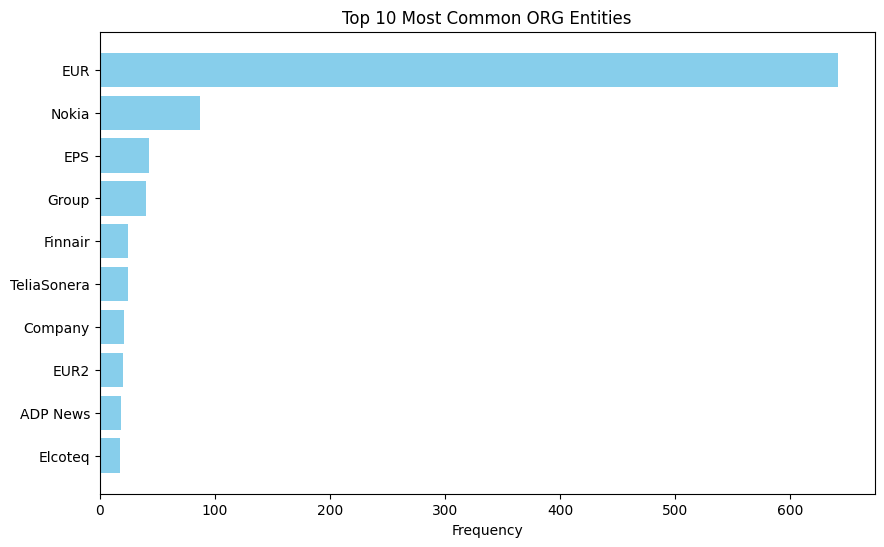

"\n    - You'll see that even with high-level NLP processing libraries such as `spaCy`, you still get errors such as processing EUR as a company\n"

In [ ]:
"""
6. Named Entity Recognition (NER) using `spaCy`
"""

# load the spaCy model (`en_core_web_sm`)
nlp = spacy.load('en_core_web_sm')

# process the text by concatenating the entire 'text' column in the original DataFrame
doc = nlp(X.str.cat(sep=' '))

# extract named entities
for entity in doc.ents:
    print(entity.text, entity.label_)

### Extension: count the number of times ORG (Organizations) appear ###

# import matplotlib for visualizations
import matplotlib.pyplot as plt

# extract and count 'ORG' entities
org_entities = [entity.text for entity in doc.ents if entity.label_ == 'ORG']
org_counts = Counter(org_entities)

# get 10 most common 'ORG' entities
top_10_orgs = org_counts.most_common(10)
org_names, org_frequencies = zip(*top_10_orgs)

# plotting results
plt.figure(figsize=(10, 6))
plt.barh(org_names, org_frequencies, color='skyblue')
plt.xlabel('Frequency')
plt.title('Top 10 Most Common ORG Entities')
plt.gca().invert_yaxis()  # invert y-axis to display the highest frequency at the top
plt.show()

"""
    - You'll see that even with high-level NLP processing libraries such as `spaCy`, you still get errors such as processing EUR as a company
"""
